In [1]:
import pandas as pd
import numpy as np
import os
from pixell import utils, enmap, enplot, curvedsky
import healpy as hp
from multiprocessing import Pool
from cosmikyu import sehgal, stats, utils as cutils
from orphics import sehgal as osehgal

import matplotlib.pyplot as plt
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
def input_path(file_name):
    return os.path.join(input_dir, file_name)

In [3]:
overwrite=False
radio_source_file = input_path("radio.cat")
radio_spectra_index_file = input_path("radio_spectra_index.npy")

if not os.path.exists(radio_spectra_index_file) or overwrite:
    ## 1.4, 30, 90, 148, 219, 277, 350 GHz
    
    radio_cat = np.loadtxt(radio_source_file, usecols=(3,4,5,6,7,8,9), dtype=np.float32)
    loc = np.where(radio_cat[:,3]<=7)
    radio_cat = radio_cat[loc[0],:]
    radio_spectra_index = radio_cat/radio_cat[:,3][:,None]
    radio_spectra_index = radio_spectra_index[:,[0,1,2,4,5,6]]
    radio_spectra_index = np.log(radio_spectra_index)
    
    freq_ratio = np.array([1.4, 30, 90, 219, 277, 350])/148
    ln_freq_ratio = np.log(freq_ratio)
    

    radio_spectra_index = radio_spectra_index/(ln_freq_ratio[:,None].T)
    radio_spectra_index = np.mean(radio_spectra_index, axis=1)
    np.save(radio_spectra_index_file, radio_spectra_index)
else: 
    radio_spectra_index = np.load(radio_spectra_index_file)


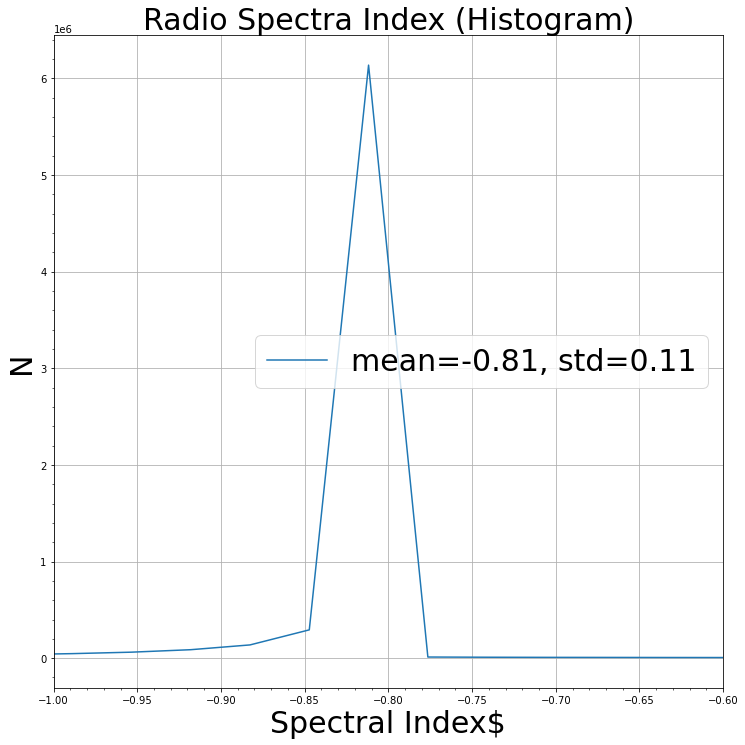

In [13]:
nbins = 100
minval = np.min(radio_spectra_index)
maxval = np.max(radio_spectra_index)
mean = np.mean(radio_spectra_index)
std = np.std(radio_spectra_index)
FB = stats.FastBINNER(minval, maxval, nbins)
bin_center, index_binned = FB.bin(radio_spectra_index)

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
plt.plot(bin_center, index_binned, label=f"mean={mean:.2f}, std={std:.2f}")
plt.yscale("log")
plt.legend(fontsize=30)
plt.title("Radio Spectra Index (Histogram)", fontsize=30)
plt.ylabel("N", fontsize=30)
plt.xlabel(r"Spectral Index$", fontsize=30)
plt.yscale("linear")
plt.xlim(-1,-0.6)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
plt.show()

In [5]:
overwrite=True
blast_source_file = input_path("IRBlastPop.dat")
cib_spectra_index_file = input_path("cib_spectra_index.npy")
cib_spectra_index = None

input_files = [blast_source_file]
for i in range(1,11):
    input_files.append(input_path(f"IRgal_S_{i}.dat"))
    
if not os.path.exists(cib_spectra_index_file) or overwrite:
    for input_file in input_files:
        print(f"processing {input_file}")
        #30, 90, 148, 219, 277, 350

        cib_cat = np.loadtxt(input_file, usecols=(4,5,6,7,8,9), dtype=np.float32)
        print(cib_cat.shape)
        cib_cat[:,-1] *= 0.75 ## apply scaling
        loc = np.where(cib_cat[:,2]<=7)
        if len(loc[0]) == 0:
            print(f"skipping {input_file}")
            continue

        cib_cat = cib_cat[loc[0],:]
        index = cib_cat/cib_cat[:,2][:,None]
        index = index[:,[0,1,3,4,5]]
        index = np.log(index)

        freq_ratio = np.array([30, 90, 219, 277, 350])/148
        ln_freq_ratio = np.log(freq_ratio)


        index = index/(ln_freq_ratio[:,None].T)
        index = np.mean(index, axis=1)            
            
        
        if cib_spectra_index is None:
            cib_spectra_index = index
        else:
            cib_spectra_index = np.concatenate((cib_spectra_index, index))
        print(cib_spectra_index.shape)
        
    np.save(cib_spectra_index_file, cib_spectra_index)
else: 
    cib_spectra_index = np.load(cib_spectra_index_file)

processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRBlastPop.dat
(298, 6)
skipping /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRBlastPop.dat
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRgal_S_1.dat
(120515, 6)
(120515,)
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRgal_S_2.dat
(202454143, 6)
(202574658,)
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRgal_S_3.dat
(288651012, 6)
(491225670,)
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRgal_S_4.dat
(97035844, 6)
(588261514,)
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/IRgal_S_5.dat
(28206797, 6)
(616468311,)
processing /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July

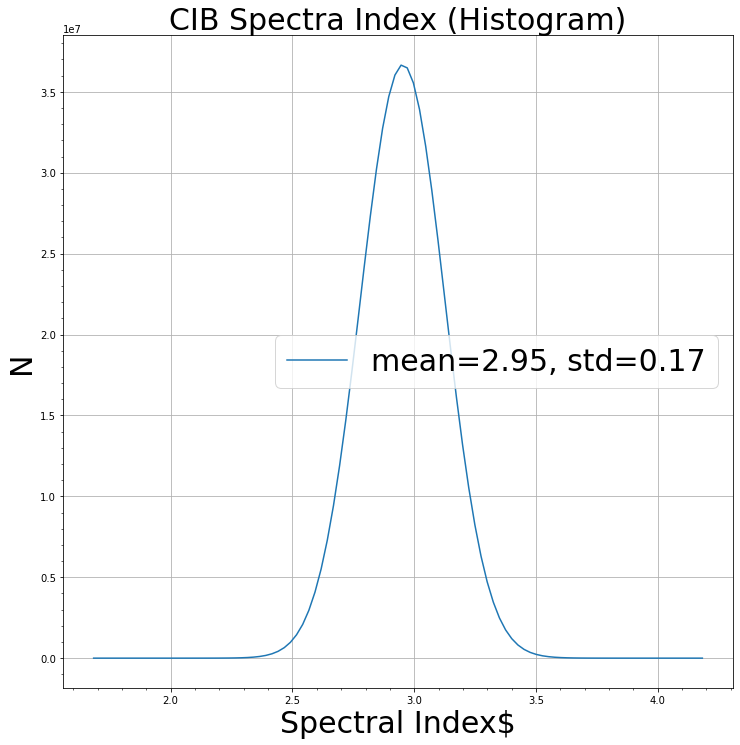

In [10]:
nbins = 100
minval = np.min(cib_spectra_index)
maxval = np.max(cib_spectra_index)
mean = np.mean(cib_spectra_index)
std = np.std(cib_spectra_index)
FB = stats.FastBINNER(minval, maxval, nbins)
bin_center, index_binned = FB.bin(cib_spectra_index)

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
plt.plot(bin_center, index_binned, label=f"mean={mean:.2f}, std={std:.2f}")
plt.yscale("log")
plt.legend(fontsize=30)
plt.title("CIB Spectra Index (Histogram)", fontsize=30)
plt.ylabel("N", fontsize=30)
plt.xlabel(r"Spectral Index$", fontsize=30)
plt.yscale("linear")
#plt.ylim(1e-1,0.25)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
plt.show()

In [7]:
cib_spectra_index


array([2.77141335, 2.7348871 , 2.76733671, ..., 3.26822381, 3.17933816,
       3.407235  ])